# Convolutional Neural Network (CNN)

Starting by importing the necessary modules

In [116]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from google.colab.patches import cv2_imshow

1. Import the libraries, load dataset, print shape of data, visualize the images in dataset. (5 Marks) 


Before importing the data files, I will ensure my drive is mounted to my runtime

In [117]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importing the image data into a numpy array

In [118]:
path = '/content/drive/My Drive/AIML/UT_Austin/7-Convolutional Neural Networks/Module_7_Project/'

data = np.load(os.path.join(path, 'images.npy'))
print('shape: ', data.shape)

shape:  (4750, 128, 128, 3)


In [119]:
ims = data.copy()

Importing the labels into a dataframe

In [120]:
labels = pd.read_csv(os.path.join(path, 'Labels.csv'))
print('shape: ', labels.shape)
print(labels['Label'].unique(), labels['Label'].unique().shape)

shape:  (4750, 1)
['Small-flowered Cranesbill' 'Fat Hen' 'Shepherds Purse' 'Common wheat'
 'Common Chickweed' 'Charlock' 'Cleavers' 'Scentless Mayweed' 'Sugar beet'
 'Maize' 'Black-grass' 'Loose Silky-bent'] (12,)


* we can see above that there are 12 unique labels corresponding to 12 species of plant

Let's visualize some of the images in the dataset

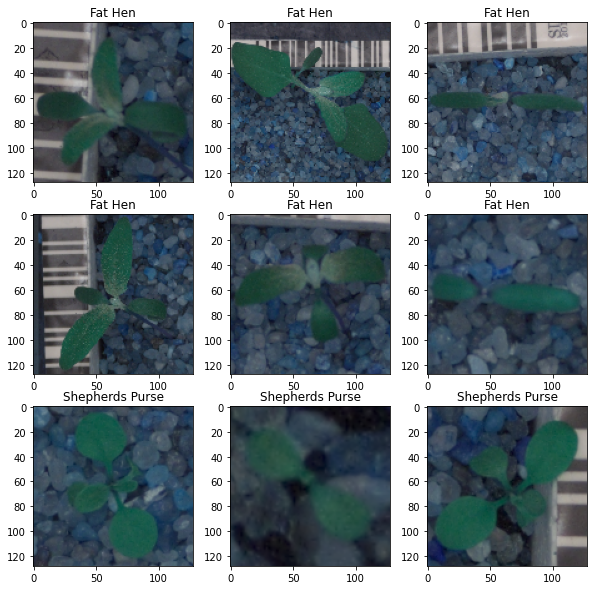

In [121]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.title(labels.iloc[i+965]['Label'])
  plt.imshow(data[(i+965)])
plt.show()

Next we will use the Sobel operator to show an example of edge detection compared to the input image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


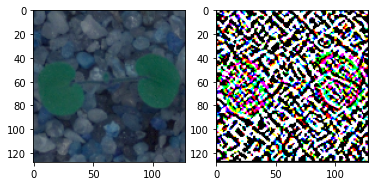

In [122]:
sobel = cv2.Sobel(data[0], cv2.CV_64F, 1, 1, ksize=5)

plt.subplot(1, 2, 1)
plt.imshow(data[0])
plt.subplot(1, 2, 2)
plt.imshow(sobel)
plt.show()

* There is some evidence that there are edges, but we will want to do some more pre-processing to reduce noise.

## Data Pre-processing

### Gaussian Blurring and grayscale

first I will take a sample image and convert it to grayscale

original image: 


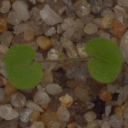

grayscale image: 


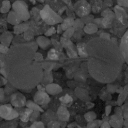

In [123]:
print("original image: ")
cv2_imshow(data[0])
image = cv2.cvtColor(data[0], cv2.COLOR_RGB2GRAY)
print('grayscale image: ')
cv2_imshow(image)

second, let's perform gaussian blurring on the grayscale image

Original Image: 


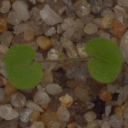

Grascale Image: 


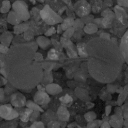

Blurring with kernel size (5, 5): 


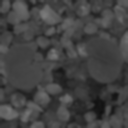

Blurring with kernel size (15, 15):


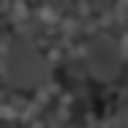

In [124]:
print('Original Image: ')
cv2_imshow(data[0])
print('Grascale Image: ')
cv2_imshow(image)
print('Blurring with kernel size (5, 5): ')
k5 = cv2.GaussianBlur(image, (5, 5), 0)
cv2_imshow(k5)
print('Blurring with kernel size (15, 15):')
k15 = cv2.GaussianBlur(image, (15, 15), 0)
cv2_imshow(k15)

Let's view the Sobel output on the transformed images

Sobel on grayscale: 


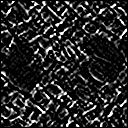

Sobel on grayscale and Guassian Blur


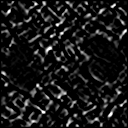

Sobel on Guassian Blur


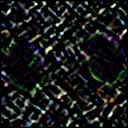

In [125]:
print('Sobel on grayscale: ')
cv2_imshow(cv2.Sobel(image, cv2.CV_64F, 1, 1, ksize=5))
print('Sobel on grayscale and Guassian Blur')
cv2_imshow(cv2.Sobel(k5, cv2.CV_64F, 1, 1, ksize=5))
print('Sobel on Guassian Blur')
gb5 = cv2.GaussianBlur(data[0], (5, 5), 0)
cv2_imshow(cv2.Sobel(gb5, cv2.CV_64F, 1, 1, ksize=5))

* I am only going to apply gaussian blurring to the dataset for the first run through of the CNN model

In [126]:
gb = []
for i in range(data.shape[0]):
  gb.append(cv2.GaussianBlur(data[i], (5, 5), 0))
len(gb)

4750

In [127]:
data = np.array(gb)

In [128]:
data.shape

(4750, 128, 128, 3)

let's print out an image to view an example of the preprocessed data

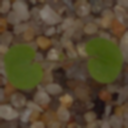

In [129]:
cv2_imshow(data[0])

## Make the data compatible

### Normalization

Let's scale our data by dividing each pixel value by 255

In [130]:
X = data/255.0
X.shape

(4750, 128, 128, 3)

In [131]:
X[0]

array([[[0.14117647, 0.2       , 0.29019608],
        [0.15294118, 0.21176471, 0.29803922],
        [0.18823529, 0.24705882, 0.3254902 ],
        ...,
        [0.30588235, 0.36862745, 0.43137255],
        [0.30588235, 0.36470588, 0.42745098],
        [0.30588235, 0.36470588, 0.42745098]],

       [[0.14509804, 0.20392157, 0.29019608],
        [0.16078431, 0.21960784, 0.30196078],
        [0.2       , 0.2627451 , 0.3372549 ],
        ...,
        [0.30980392, 0.36862745, 0.43137255],
        [0.30980392, 0.36862745, 0.42745098],
        [0.30980392, 0.36470588, 0.42352941]],

       [[0.14901961, 0.21176471, 0.29411765],
        [0.17254902, 0.23529412, 0.30980392],
        [0.22352941, 0.28627451, 0.35686275],
        ...,
        [0.30980392, 0.36470588, 0.42352941],
        [0.30980392, 0.36862745, 0.42352941],
        [0.30980392, 0.36862745, 0.42352941]],

       ...,

       [[0.15294118, 0.21176471, 0.27843137],
        [0.15686275, 0.21568627, 0.28235294],
        [0.16470588, 0

### Label Encoding
we will need to encode our plant labels. Let's use pd.get_dummies

In [132]:
y = np.array(pd.get_dummies(labels['Label'])).astype(int)
y.shape

(4750, 12)

### Split the data

In [133]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=14)

printing out the first instance of y_train to show encoded label

we will also want to create a validation set

In [134]:
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state=14)

let's check the shape of our training, testing, and validation datasets to ensure compatibility

In [135]:
print('X_train: ', X_train.shape)
print('X_test: ', X_test.shape)
print('X_val: ', X_val.shape)
print('\n')
print('y_train: ', y_train.shape)
print('y_test: ', y_test.shape)
print('y_val: ', y_val.shape)

X_train:  (3325, 128, 128, 3)
X_test:  (713, 128, 128, 3)
X_val:  (712, 128, 128, 3)


y_train:  (3325, 12)
y_test:  (713, 12)
y_val:  (712, 12)


* the shape of our data is compatible 

## CNN - building the model

First things first, we will create our model using a common pattern of **Conv2D** and **MaxPooling2D** layers

In [136]:
model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu", input_shape=X_train.shape[1:]))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
model.add(layers.Conv2D(64, (5, 5), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.4))
model.add(layers.Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(12, activation="softmax"))

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 64)      256       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 64, 64, 64)        102464    
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 32, 32, 64)       

Set up the optimizer for our model and compile our model using *categorical_crossentropy*

In [137]:
adm = optimizers.Adam(learning_rate=0.001)

In [138]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

mc =  ModelCheckpoint('cifar_cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

In [139]:
import tensorflow as tf

model.compile(loss="categorical_crossentropy",
              optimizer=adm,
              metrics=['accuracy'])

Time to fit the data to our model

In [140]:
history = model.fit(X_train, y_train, epochs=10, 
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    verbose=1, callbacks=[es,mc])

Epoch 1/10
104/104 [==============================] - 5s 40ms/step - loss: 5.4602 - accuracy: 0.1525 - val_loss: 2.5795 - val_accuracy: 0.0576

Epoch 00001: val_loss improved from inf to 2.57948, saving model to cifar_cnn_checkpoint_01_loss2.5795.h5
Epoch 2/10
104/104 [==============================] - 4s 38ms/step - loss: 1.9851 - accuracy: 0.3126 - val_loss: 2.9733 - val_accuracy: 0.0913

Epoch 00002: val_loss did not improve from 2.57948
Epoch 3/10
104/104 [==============================] - 4s 38ms/step - loss: 1.7033 - accuracy: 0.4119 - val_loss: 3.4787 - val_accuracy: 0.0576

Epoch 00003: val_loss did not improve from 2.57948
Epoch 4/10
104/104 [==============================] - 4s 38ms/step - loss: 1.4831 - accuracy: 0.4780 - val_loss: 3.3110 - val_accuracy: 0.1166

Epoch 00004: val_loss did not improve from 2.57948
Epoch 5/10
104/104 [==============================] - 4s 38ms/step - loss: 1.3983 - accuracy: 0.5240 - val_loss: 2.0496 - val_accuracy: 0.2500

Epoch 00005: val_loss

We can plot out the accuracy and val_accuracy scores to visualize the accuracy of our model

23/23 - 0s - loss: 2.3839 - accuracy: 0.2598


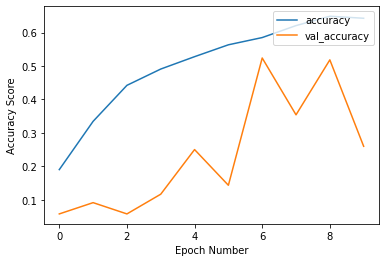

In [141]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy Score')
plt.legend(loc='upper right')

tl, ta = model.evaluate(X_val,  y_val, verbose=2)

Let's create a confusion matrix to further evaluate our results

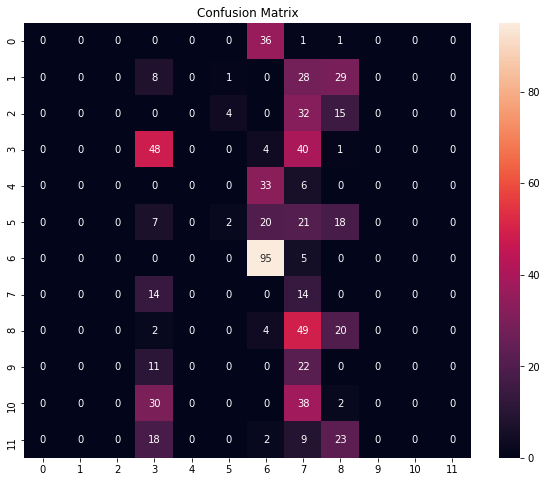

In [142]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_predict = model.predict(X_test)

y_pred = []
for val in y_predict:
    y_pred.append(np.argmax(val))

yt = []
for val in y_test:
  yt.append(np.argmax(val))

cm = confusion_matrix(yt,y_pred)
plt.figure(figsize=(10,8))
plt.title('Confusion Matrix')
sns.heatmap(cm, annot=True)
plt.show()

* based on the above confusion matrix, we can see that our model performs okay.  It has trouble predicting for label 11.

In [143]:
labels['Label'].unique()

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

* Label 11 is tied to 'Loose Silky-bent'.  Below, we can see that this plant does have the most occurences.  Even so, the skew towards label 11 seems quite high

In [144]:
labels['Label'].value_counts()

Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Maize                        221
Common wheat                 221
Name: Label, dtype: int64

Finally, let's view some of the test results compared to the predicted labels

Actual Labels


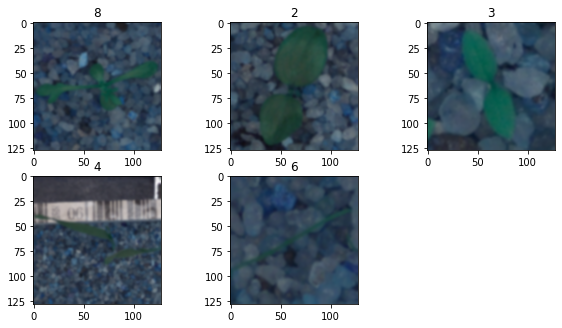

Predicted Labels


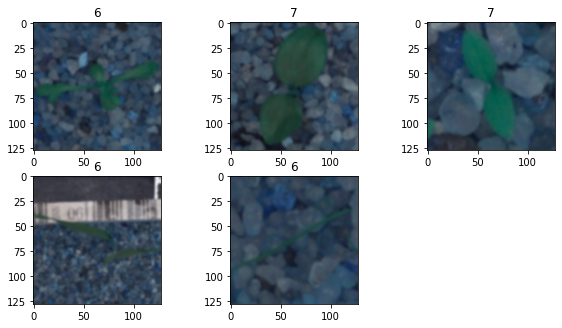

In [145]:
print('Actual Labels')
n = 1
plt.figure(figsize=(10,8))
for i in [2, 3, 33, 36, 59]:
  plt.subplot(3, 3, n)
  plt.title(np.argmax(y_test[i]))
  plt.imshow(X_test[i])
  n += 1
plt.show()

print('Predicted Labels')
n = 1
plt.figure(figsize=(10,8))
for i in [2, 3, 33, 36, 59]:
  plt.subplot(3, 3, n)
  plt.title(np.argmax(y_predict[i]))
  plt.imshow(X_test[i])
  n += 1
plt.show()

* of this sample of 5 images, we can see that only 2 of these images were predicted correctly.  
* We can try and adjust the layers and the associated hyperparameters to improve the overall model